In [1]:
!pip install lazypredict

# Make sure Internet is turned on in the Kaggle notebook

![](https://www.intrepidstrategic.com/wp-content/uploads/2023/09/SpaceShipTitanic.png)

## Let's have some fun!
#### I'm in the early learning phase, having only picked up Python within the past year. Please, if you have feedback then let me know! I'm here to learn. 

In [2]:
import matplotlib.pyplot as plt
import random as rnd
from scipy import stats
%matplotlib inline

import seaborn as sns
import sklearn 
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier
import lazypredict
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import cv
import plotly.express as px
from IPython.display import display

# Table of Contents
1. [Examine The Problem](#problem)
2. [Load & Clean Data](#clean)
3. [Exploratory Data Analysis](#eda)
4. [Feature Engineering](#feature)
5. [Model Selection](#selection)
6. [Fine-Tuning](#tune)
7. [Modeling](#model)


<a id="problem"></a> 
# Step 1: Identify the Problem
#### People went missing!

[From Kaggle](https://www.kaggle.com/competitions/spaceship-titanic): "Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!"

<a id="start"></a> 
# Step 2: Load & Clean
## Convert CVSs to DataFrames

In [3]:
train_df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

#### I want to maintain the original files, so let's create new df names

In [4]:
train_data = train_df
test_data = test_df
combine = [train_data,test_data]

# Get a high level understanding of train_data and test_data

### First we'll look at rows & columns

In [5]:
train_data.shape

(8693, 14)

In [6]:
test_data.shape

(4277, 13)

### Take a deeper look

In [7]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [8]:
test_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.00,4195.00,4171.00,4179.00,4176.00,4197.00
mean,28.66,219.27,439.48,177.30,303.05,310.71
std,14.18,607.01,1527.66,560.82,1117.19,1246.99
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,26.00,0.00,0.00,0.00,0.00,0.00
75%,37.00,53.00,78.00,33.00,50.00,36.00
max,79.00,11567.00,25273.00,8292.00,19844.00,22272.00


**Categorical Data:**
Transported, PassengerId, CryoSleep, Cabin, HomePlanet, Destination, VIP

**Numerical Data**
Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck

#### Cabin contains a mix of the two

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


## PassengerID
A unique identifier assigned to each passenger
## HomePlanet
Where the passenger is from
## CryoSleep
If the person was in cryogenic slumber during the trip
## Destination
Where the passenger was headed
## Age
How old the individual was, in presumed years
## VIP
Importancy status of each person, either yes or no
## RoomService
How much someone spent on room service during their trip
## FoodCourt
The price each person spent at the food court
## ShoppingMall
The amount of funds each individual parted with at the shopping mall area
## Spa
The amount paid to spa services
## VRDeck
How much someone spent on their version of the holodeck
## Name
The name of each person

In [11]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [12]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.00,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.00,False,0.00,6652.00,0.00,181.00,585.00,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.00,False,10.00,0.00,635.00,0.00,0.00,Brence Harperez


### Adversarial Validation

Adversarial validation compares the train and test datasets. Here, we are identifying the Area Under the ROC Curve (AUC Score) with the aim of being close to 0.5, meaning the model is not able to differentiate between the two datasets. 
Credit for this code goes to Carl McBride Ellis, PhD. View Dr. Ellis' Kaggle notebook [What is Adversarial Validation](https://www.kaggle.com/code/carlmcbrideellis/what-is-adversarial-validation) here. 

Additional reading on Adversarial Validation can be found in the Designing Good Validation chapter in [The Kaggle Book: Data Analysis and Machine Learning for Competitive Data Science](https://www.amazon.com/Data-Analysis-Machine-Learning-Kaggle-ebook/dp/B09F3STL34), Banachewicz, Massaron, Goldbloom, 2022.

In [13]:
# Select only the numerical features
X_train = train_data.select_dtypes(include=['number']).copy()
X_test = test_data.select_dtypes(include=['number']).copy()

# Add the train/test labels
X_train["AV_label"] = 0
X_test["AV_label"] = 1

# Combine train and test data
all_data = pd.concat([X_train, X_test], axis=0, ignore_index=True)

# Shuffle the combined dataset
all_data_shuffled = all_data.sample(frac=1)

# Create the DMatrix (XGBoost data structure)
X = all_data_shuffled.drop(['AV_label'], axis=1)
y = all_data_shuffled['AV_label']
XGBdata = xgb.DMatrix(data=X, label=y)

# Define XGBoost parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "learning_rate": 0.05,
    "max_depth": 5,
}

# Perform cross-validation with XGBoost
cross_val_results = cv(
    dtrain=XGBdata,
    params=params,
    nfold=5,
    metrics="auc",
    num_boost_round=200,
    early_stopping_rounds=20,
    as_pandas=True,
)

# Print out the final result
print((cross_val_results["test-auc-mean"]).tail(1))

5   0.50
Name: test-auc-mean, dtype: float64


#### Excellent. The datasets are nearly identical. 

### <a id="clean"></a> 
# STEP 2: Clean Data

### Where are the null values?

In [14]:
null_train_data_df = pd.DataFrame(train_data.isnull().sum())
print(null_train_data_df)

                0
PassengerId     0
HomePlanet    201
CryoSleep     217
Cabin         199
Destination   182
Age           179
VIP           203
RoomService   181
FoodCourt     183
ShoppingMall  208
Spa           183
VRDeck        188
Name          200
Transported     0


In [15]:
null_test_data_df = pd.DataFrame(test_data.isnull().sum())
print(null_test_data_df)

                0
PassengerId     0
HomePlanet     87
CryoSleep      93
Cabin         100
Destination    92
Age            91
VIP            93
RoomService    82
FoodCourt     106
ShoppingMall   98
Spa           101
VRDeck         80
Name           94


#### They are in every column except for PassengerID and Transported

## Cabin contains both numeric and categorical data. 
#### Need to fix so the iterative imputer can run to replace nan values


In [16]:
# See how Cabin is Organized
cabin=pd.DataFrame(train_data['Cabin'].unique())
cabin.head(5)

,0
0,B/0/P
1,F/0/S
2,A/0/S
3,F/1/S
4,F/0/P


## Cabin is broken down into Deck / Number / Side. Deck is A-E, side is P for "Port" or S for "Starboard"

## Break down the cabin by new features: Deck, Number, Side

In [17]:
# Function to split the 'Cabin' column into 'Deck', 'Number', and 'Side' columns
def split_cabin_column(data):
    split_data = data['Cabin'].str.split('/', expand=True)
    data['Deck'] = split_data[0]
    data['Number'] = split_data[1]
    data['Side'] = split_data[2]

# Apply the function to both train_data and test_data
split_cabin_column(train_data)
split_cabin_column(test_data)

# Drop Cabin
train_data.drop('Cabin', axis=1, inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

# Print the updated DataFrames
print("Train Data:")
print(train_data)

print("\nTest Data:")
print(test_data)

# Print the updated DataFrames
print("Train Data:")
print(train_data)

print("\nTest Data:")
print(test_data)

# Now check for null values in the DataFrames
null_train_data_df = pd.DataFrame(train_data.isnull().sum())
print(null_train_data_df)


Train Data:
     PassengerId HomePlanet CryoSleep    Destination   Age    VIP  \
0        0001_01     Europa     False    TRAPPIST-1e 39.00  False   
1        0002_01      Earth     False    TRAPPIST-1e 24.00  False   
2        0003_01     Europa     False    TRAPPIST-1e 58.00   True   
3        0003_02     Europa     False    TRAPPIST-1e 33.00  False   
4        0004_01      Earth     False    TRAPPIST-1e 16.00  False   
...          ...        ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    55 Cancri e 41.00   True   
8689     9278_01      Earth      True  PSO J318.5-22 18.00  False   
8690     9279_01      Earth     False    TRAPPIST-1e 26.00  False   
8691     9280_01     Europa     False    55 Cancri e 32.00  False   
8692     9280_02     Europa     False    TRAPPIST-1e 44.00  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0            0.00       0.00          0.00    0.00    0.00    Maham Ofracculy 

## The PassengerID shows if people are together. I want two columns: 'Solo' and 'GroupSize'


In [18]:
# Extract the room number from PassengerID
train_data['Room'] = train_data['PassengerId'].str.extract(r'(\d{4})')[0]
test_data['Room'] = test_data['PassengerId'].str.extract(r'(\d{4})')[0]

# Extract the passenger number from PassengerID
train_data['PassengerNum'] = train_data['PassengerId'].str.extract(r'_(\d{2})')[0]
test_data['PassengerNum'] = test_data['PassengerId'].str.extract(r'_(\d{2})')[0]

# Convert 'PassengerNum' to numeric
train_data['PassengerNum'] = pd.to_numeric(train_data['PassengerNum'])
test_data['PassengerNum'] = pd.to_numeric(test_data['PassengerNum'])

# Create the 'GroupNum' column by counting the number of passengers in each room
train_data['GroupNum'] = train_data.groupby('Room')['PassengerNum'].transform('max')
test_data['GroupNum'] = test_data.groupby('Room')['PassengerNum'].transform('max')

# Create the 'Solo' column
train_data['Solo'] = (train_data['GroupNum'] == 1).astype(int)
test_data['Solo'] = (test_data['GroupNum'] == 1).astype(int)

# Drop temporary columns used for calculations
train_data.drop(['Room', 'PassengerNum'], axis=1, inplace=True)
test_data.drop(['Room', 'PassengerNum'], axis=1, inplace=True)

## Let's make lists of numeric vs categorical values


In [19]:
numeric_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Number', 'Solo', 'PassengerNum']
categorical_columns = [col for col in train_data.columns if col not in numeric_columns and col not in ['Name', 'Transported', 'PassengerId']]

## One-Hot Encode Categorical Columns

In [20]:
train_data = pd.get_dummies(train_data, columns=categorical_columns)
test_data = pd.get_dummies(test_data, columns=categorical_columns)

#Verify

print("Train Data")
train_data.info()

print("\nTest Data")
test_data.info()

Train Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                8693 non-null   object 
 1   Age                        8514 non-null   float64
 2   RoomService                8512 non-null   float64
 3   FoodCourt                  8510 non-null   float64
 4   ShoppingMall               8485 non-null   float64
 5   Spa                        8510 non-null   float64
 6   VRDeck                     8505 non-null   float64
 7   Name                       8493 non-null   object 
 8   Transported                8693 non-null   bool   
 9   Number                     8494 non-null   object 
 10  Solo                       8693 non-null   int64  
 11  HomePlanet_Earth           8693 non-null   bool   
 12  HomePlanet_Europa          8693 non-null   bool   
 13  HomePlanet_Mars            8693 non-n

## Knock out the nan null values with Imputation

In [21]:
# Select numeric columns for imputation (excluding 'Name' and 'Transported')
numeric_columns = [col for col in train_data.columns if col not in categorical_columns and col not in ['Name', 'Transported', 'PassengerId']]


In [22]:
# Format the column names with quotes and commas
columns_in_quotes = ', '.join(['"' + col + '"' for col in numeric_columns])

print(columns_in_quotes)

"Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Number", "Solo", "HomePlanet_Earth", "HomePlanet_Europa", "HomePlanet_Mars", "CryoSleep_False", "CryoSleep_True", "Destination_55 Cancri e", "Destination_PSO J318.5-22", "Destination_TRAPPIST-1e", "VIP_False", "VIP_True", "Deck_A", "Deck_B", "Deck_C", "Deck_D", "Deck_E", "Deck_F", "Deck_G", "Deck_T", "Side_P", "Side_S", "GroupNum_1", "GroupNum_2", "GroupNum_3", "GroupNum_4", "GroupNum_5", "GroupNum_6", "GroupNum_7", "GroupNum_8"


In [23]:
# Create the IterativeImputer and perform imputation on numeric columns of train_data_encoded
numeric_imputer = IterativeImputer(max_iter=10, random_state=48, verbose=2)
imputed_train_numeric = numeric_imputer.fit_transform(train_data[numeric_columns])
imputed_test_numeric = numeric_imputer.transform(test_data[numeric_columns])

[IterativeImputer] Completing matrix with shape (8693, 36)
[IterativeImputer] Ending imputation round 1/10, elapsed time 2.49
[IterativeImputer] Change: 2560.5055377763297, scaled tolerance: 29.813000000000002 
[IterativeImputer] Ending imputation round 2/10, elapsed time 4.69
[IterativeImputer] Change: 71.03361361401198, scaled tolerance: 29.813000000000002 
[IterativeImputer] Ending imputation round 3/10, elapsed time 6.37
[IterativeImputer] Change: 0.38963978962243573, scaled tolerance: 29.813000000000002 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (4277, 36)
[IterativeImputer] Ending imputation round 1/3, elapsed time 0.02
[IterativeImputer] Ending imputation round 2/3, elapsed time 0.02
[IterativeImputer] Ending imputation round 3/3, elapsed time 0.04


In [24]:
# Create DataFrames from the imputed numeric values
imputed_train_numeric_df = pd.DataFrame(imputed_train_numeric, columns=numeric_columns)
imputed_test_numeric_df = pd.DataFrame(imputed_test_numeric, columns=numeric_columns)

In [25]:
# Replace the original numeric columns in train_data_encoded and test_data_encoded with imputed values
train_data[numeric_columns] = imputed_train_numeric_df
test_data[numeric_columns] = imputed_test_numeric_df

In [26]:
# Select categorical columns for imputation (excluding 'Name' and 'Transported')
categorical_columns = [col for col in train_data.columns if col in categorical_columns and col not in ['Name', 'Transported', 'PassengerId']]

### And Verify

In [27]:
null_train_data_df = pd.DataFrame(train_data.isnull().sum())
print(null_train_data_df)

                             0
PassengerId                  0
Age                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Name                       200
Transported                  0
Number                       0
Solo                         0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
CryoSleep_False              0
CryoSleep_True               0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
VIP_False                    0
VIP_True                     0
Deck_A                       0
Deck_B                       0
Deck_C                       0
Deck_D                       0
Deck_E                       0
Deck_F                       0
Deck_G                       0
Deck_T                       0
Side_P                       0
Side_S                       0
GroupNum

In [28]:
null_test_data_df = pd.DataFrame(train_data.isnull().sum())
print(null_test_data_df)

                             0
PassengerId                  0
Age                          0
RoomService                  0
FoodCourt                    0
ShoppingMall                 0
Spa                          0
VRDeck                       0
Name                       200
Transported                  0
Number                       0
Solo                         0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
CryoSleep_False              0
CryoSleep_True               0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
VIP_False                    0
VIP_True                     0
Deck_A                       0
Deck_B                       0
Deck_C                       0
Deck_D                       0
Deck_E                       0
Deck_F                       0
Deck_G                       0
Deck_T                       0
Side_P                       0
Side_S                       0
GroupNum

<a id="eda"></a> 
# Step 3: Exploratory Data Analysis

#### Data tells a story. Let's uncover the story.

## View Transported vs Non-Transported

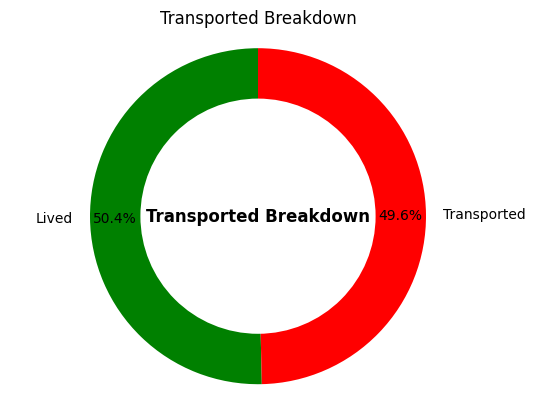

In [29]:
# Count the number of people in each category
transported_counts = train_data['Transported'].value_counts()

# Create a figure and axis
fig, ax = plt.subplots()

# Define colors
colors = ['green', 'red']

# Create a donut chart
ax.pie(transported_counts, labels=['Lived', 'Transported'], colors=colors,
       autopct='%1.1f%%', startangle=90, pctdistance=0.85)

# Draw a white circle at the center
center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(center_circle)

# Add title to the center
plt.text(0, 0, "Transported Breakdown", ha='center', va='center', fontsize=12, fontweight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

plt.title("Transported Breakdown")

# Display the plot
plt.show()

#### Pretty even!

# Look at immediate correlations on numeric columns

In [30]:
numeric = [    'Age',
    'RoomService',
    'FoodCourt',
    'ShoppingMall',
    'Spa',
    'VRDeck',
    'Number',
    'HomePlanet_Earth',
    'HomePlanet_Europa',
    'HomePlanet_Mars',
    'CryoSleep_False',
    'CryoSleep_True',
    'Destination_55 Cancri e',
    'Destination_PSO J318.5-22',
    'Destination_TRAPPIST-1e',
    'VIP_False',
    'VIP_True',
    'Deck_A',
    'Deck_B',
    'Deck_C',
    'Deck_D',
    'Deck_E',
    'Deck_F',
    'Deck_G',
    'Deck_T',
    'Side_P',
    'Side_S',
    'GroupNum_1',
    'GroupNum_2',
    'GroupNum_3',
    'GroupNum_4',
    'GroupNum_5',
    'GroupNum_6',
    'GroupNum_7',
    'GroupNum_8']

numeric_data = train_data[numeric]
correlation_matrix_numeric = numeric_data.corr()

print("Numeric Correlations:")
print(correlation_matrix_numeric)

Numeric Correlations:
                            Age  RoomService  FoodCourt  ShoppingMall   Spa  \
Age                        1.00         0.07       0.13          0.03  0.13   
RoomService                0.07         1.00      -0.02          0.06  0.01   
FoodCourt                  0.13        -0.02       1.00         -0.01  0.22   
ShoppingMall               0.03         0.06      -0.01          1.00  0.02   
Spa                        0.13         0.01       0.22          0.02  1.00   
VRDeck                     0.10        -0.02       0.23         -0.01  0.15   
Number                    -0.13        -0.01      -0.18          0.00 -0.13   
HomePlanet_Earth          -0.20        -0.14      -0.21         -0.07 -0.16   
HomePlanet_Europa          0.22        -0.07       0.37         -0.02  0.27   
HomePlanet_Mars            0.02         0.25      -0.13          0.11 -0.09   
CryoSleep_False            0.07         0.25       0.21          0.21  0.20   
CryoSleep_True            -0.0

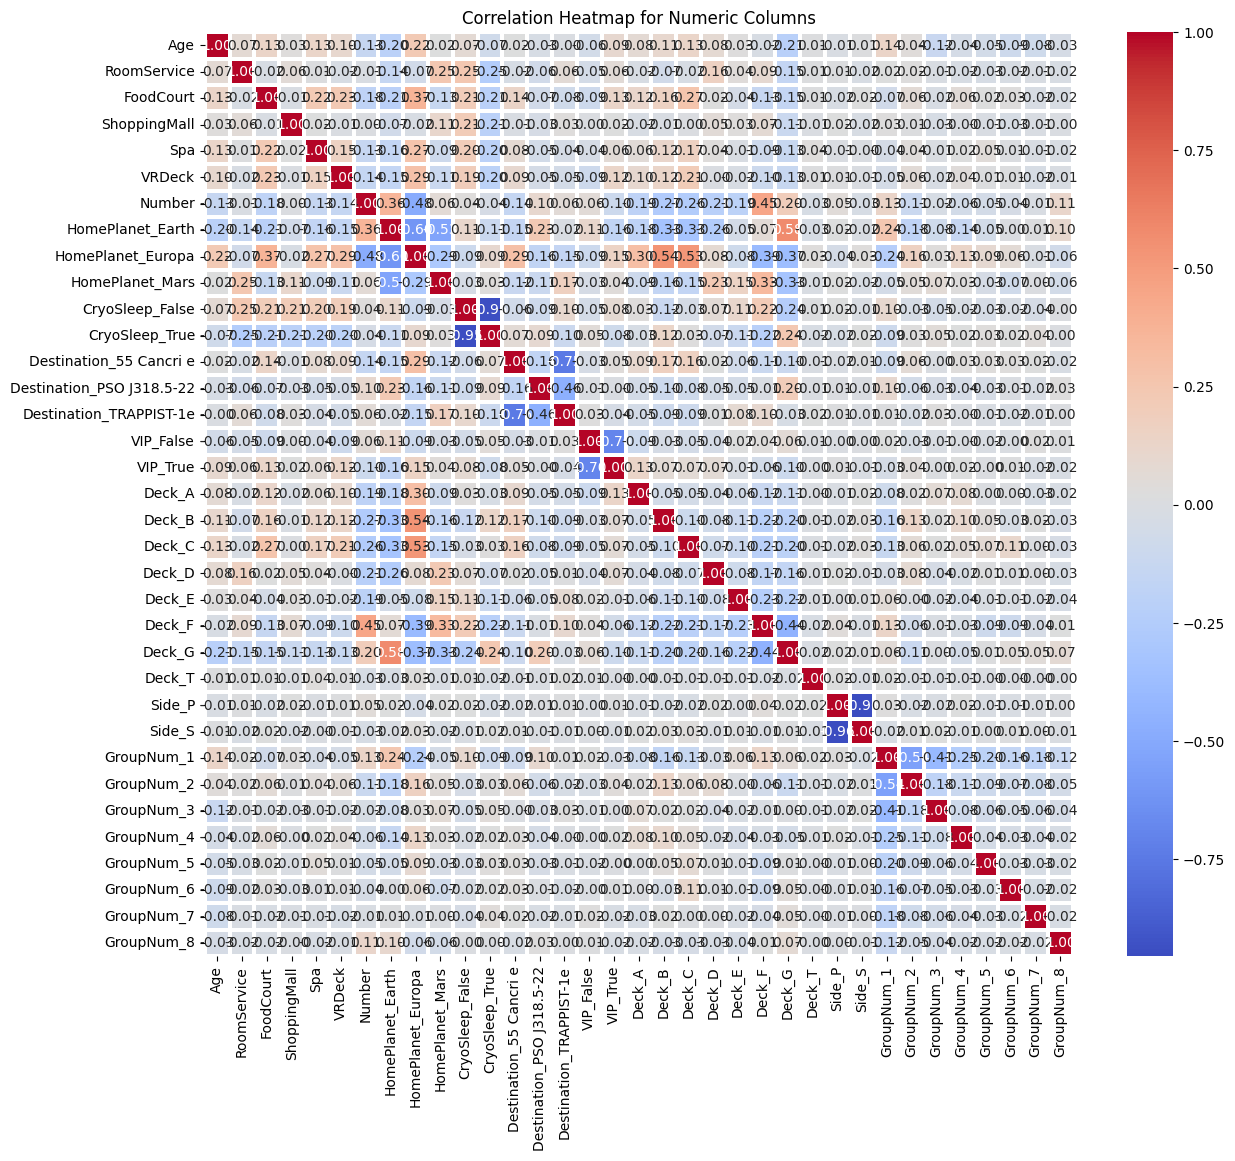

In [31]:
# Create a DataFrame with only the selected numeric columns
numeric_data = train_data[numeric]

# Compute the correlation matrix
correlation_matrix_numeric = numeric_data.corr()

# Create a heatmap with increased linewidths and size
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1.5)
plt.title("Correlation Heatmap for Numeric Columns")
plt.show()

#### Immediately I see correlations with where someone is from and what deck they are on with where they spent their money. 


## Look at Home Planet & Destination
#### Look at both frequency and broken down into transported vs non-transported

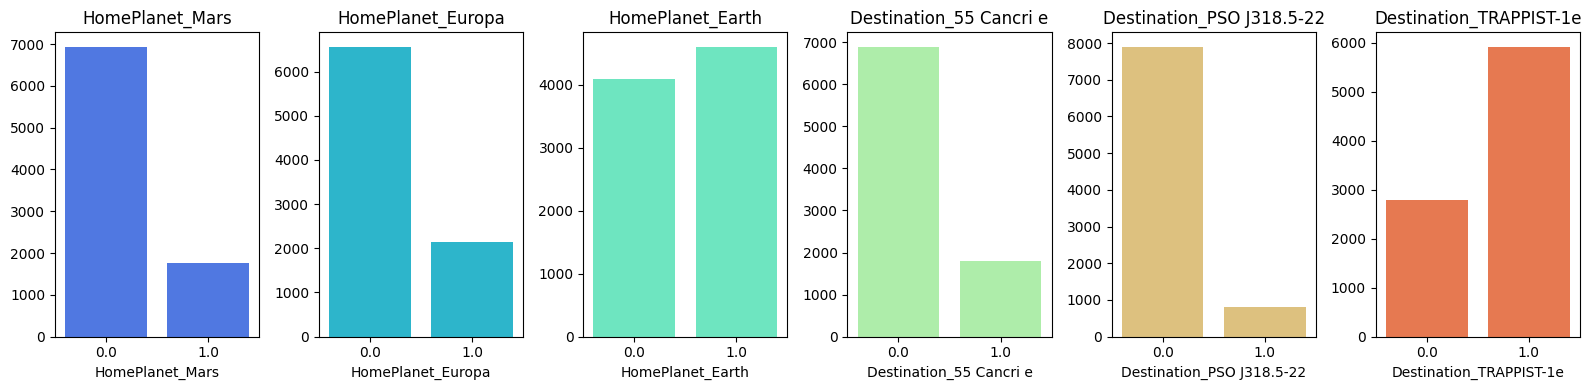

In [32]:
# Columns of interest
columns_of_interest = [
    'HomePlanet_Mars', 'HomePlanet_Europa', 'HomePlanet_Earth',
    'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e'
]

# Create a figure with subplots for each column
fig, axes = plt.subplots(1, len(columns_of_interest), figsize=(16, 4))

# Rainbow color palette
colors = sns.color_palette('rainbow', len(columns_of_interest))

# Plot bar charts of column values
for i, col in enumerate(columns_of_interest):
    sns.countplot(x=col, data=train_data, ax=axes[i], palette=[colors[i]])
    axes[i].set_title(col)

# Remove y-axis labels for better visualization
for ax in axes:
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

# Jeez. People from Earth and people headed to Trappist are screwed

#### Where are people from Earth headed to?

In [33]:
# Filter the data for people with HomePlanet_Earth equal to 1
earth_data = train_data[train_data['HomePlanet_Earth'] == 1]

# Create a new DataFrame to hold the Treemap data
treemap_data = []

# Define the six boxes and their conditions
boxes = [
    ('55 Cancri e', 'darkgreen', 'lightgreen'),
    ('PSO J318.5-22', 'darkgoldenrod', 'lightgoldenrodyellow'),
    ('TRAPPIST-1e', 'darkorange', 'lightcoral')
]

# Iterate through the boxes and add data to the Treemap
for destination, dark_color, light_color in boxes:
    # Filter data for the specific destination
    destination_data = earth_data[earth_data[f'Destination_{destination}'] == 1]
    
    # Filter data for people transported to the destination
    transported_data = destination_data[destination_data['Transported'] == True]
    
    # Calculate the sizes for the boxes
    dark_size = len(destination_data)
    light_size = len(transported_data)
    
    # Add data for the larger box
    treemap_data.append({
        'Destination': destination,
        'Transported': 'Not Transported',
        'Size': dark_size,
        'Color': dark_color
    })
    
    # Add data for the smaller box (if there are transported individuals)
    if light_size > 0:
        treemap_data.append({
            'Destination': destination,
            'Transported': 'Transported',
            'Size': light_size,
            'Color': light_color
        })

# Create the Treemap
fig = px.treemap(
    treemap_data,
    path=['Destination', 'Transported'],
    values='Size',
    color='Color',
    title='Treemap of HomePlanet_Earth and Destinations',
    width=800,
    height=600
)

fig.show()

#### Fascinating. Visually, the percentage of transported vs non-transported from Earth looks the same, even though a MASSIVE chunk of people from Earth are going to Trappist-1e

### The majority of people headed to Trappist-1e were transported. The above data doesn't reflect that they were mostly from Earth. 

## Let's explore where people headed to Trappist-1e are from and their transported rate on another Treemap

In [34]:
# Filter the data for people with Destination_TRAPPIST-1e equal to 1
trappist_data = train_data[train_data['Destination_TRAPPIST-1e'] == 1]

# Create a new DataFrame to hold the Treemap data
treemap_data = []

# Define the six boxes and their conditions
boxes = [
    ('Mars', 'darkgreen', 'lightgreen', 'HomePlanet_Mars'),
    ('Europa', 'darkgoldenrod', 'lightgoldenrodyellow', 'HomePlanet_Europa'),
    ('Earth', 'darkorange', 'lightcoral', 'HomePlanet_Earth')
]

# Iterate through the boxes and add data to the Treemap
for planet, dark_color, light_color, homeplanet_column in boxes:
    # Filter data for the specific HomePlanet
    planet_data = trappist_data[trappist_data[homeplanet_column] == 1]
    
    # Filter data for people transported to the destination
    transported_data = planet_data[planet_data['Transported'] == True]
    
    # Calculate the sizes for the boxes
    dark_size = len(planet_data)
    light_size = len(transported_data)
    
    # Add data for the larger box
    treemap_data.append({
        'HomePlanet': planet,
        'Transported': 'Not Transported',
        'Size': dark_size,
        'Color': dark_color
    })
    
    # Add data for the smaller box (if there are transported individuals)
    if light_size > 0:
        treemap_data.append({
            'HomePlanet': planet,
            'Transported': 'Transported',
            'Size': light_size,
            'Color': light_color
        })

# Create the Treemap
fig = px.treemap(
    treemap_data,
    path=['HomePlanet', 'Transported'],
    values='Size',
    color='Color',
    title='Treemap of Destination_TRAPPIST-1e and HomePlanets',
    width=800,
    height=600
)

fig.show()

#### Where someone is from when they are headed to Trappist-1e doesn't visually seem to be a significant factor. I don't see any need to feature engineer this. 

#### In the prior heatmap, there were no immediate correlations in the Trappist-1e row, other than negative correlations with the non-Earth homeplanets

## This correlation heatmap shows only people who were transported

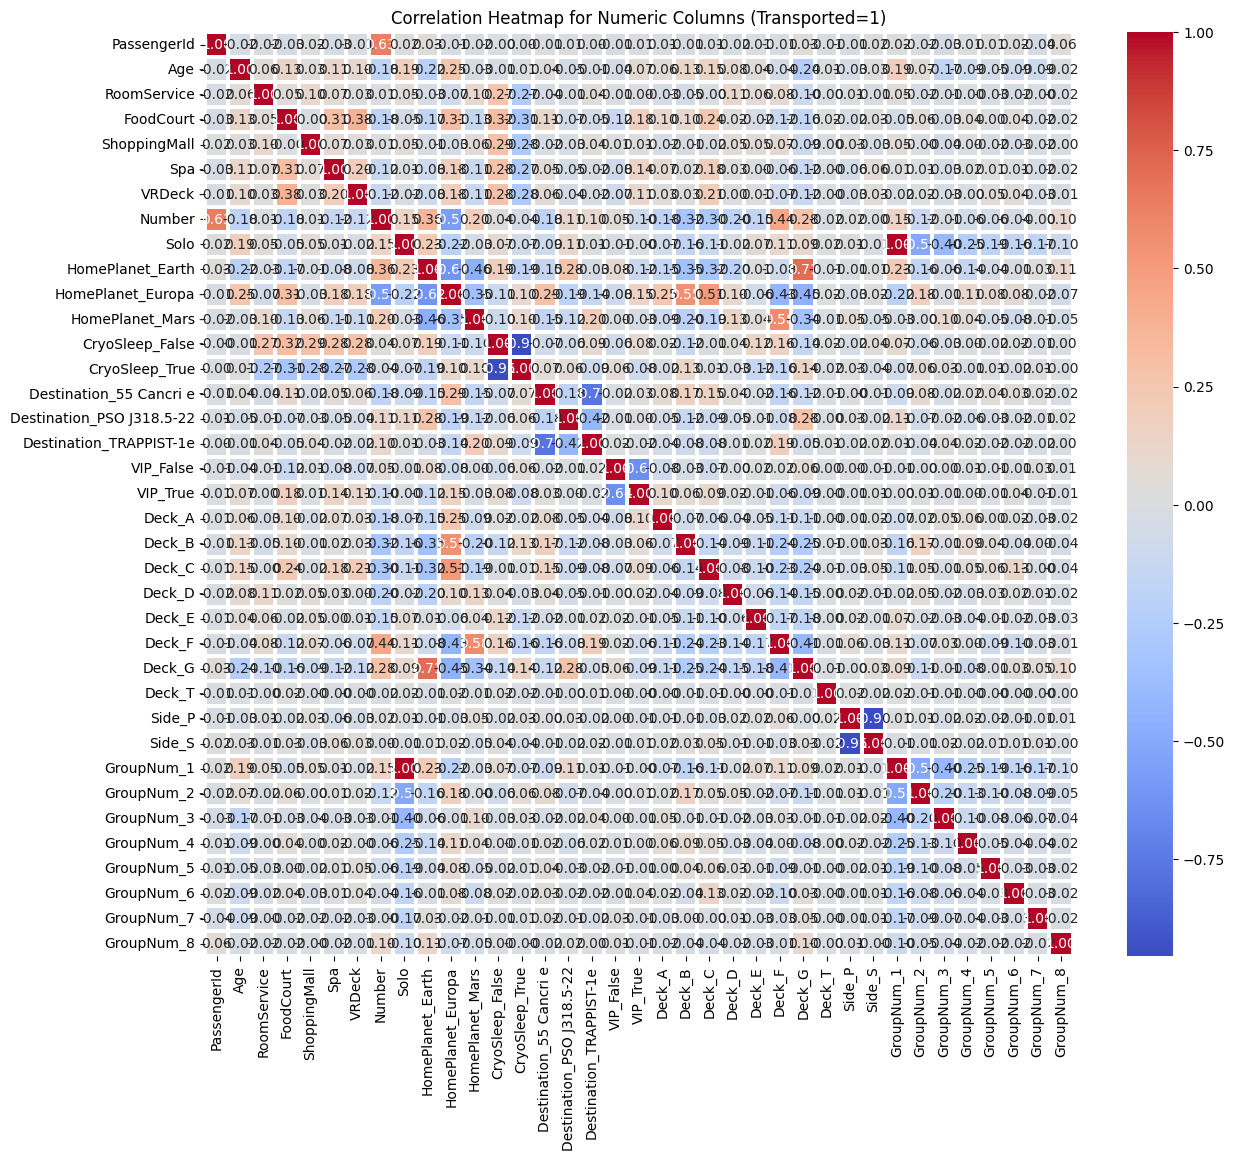

In [35]:
# Step 1: Filter the dataset for rows where 'Transported' is equal to 1
transported_data = train_data[train_data['Transported'] == 1]

# Step 2: Create a DataFrame with only the selected numeric columns
numeric_columns = [col for col in transported_data.columns if col not in categorical_columns and col not in ['Name', 'Transported']]
numeric_data = transported_data[numeric_columns]

# Step 3: Compute the correlation matrix
correlation_matrix_numeric = numeric_data.corr()

# Step 4: Create a heatmap with increased linewidths and size
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1.5)
plt.title("Correlation Heatmap for Numeric Columns (Transported=1)")
plt.show()

#### Homeplanet juxtaposed with Deck number seems to be the most important combination of factors for people who were transported

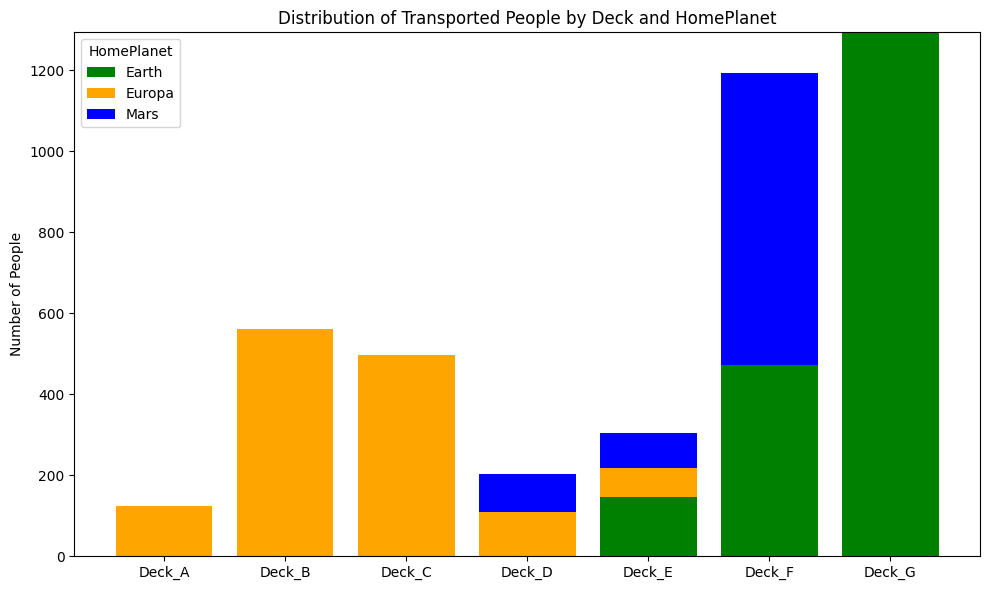

In [36]:
# Filter data for transported people
transported_data = train_data[train_data['Transported'] == True]

# Deck and HomePlanet lists
decks = ['Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G']
homeplanets = ['HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars']
colors = {'HomePlanet_Earth': 'green', 'HomePlanet_Europa': 'orange', 'HomePlanet_Mars': 'blue'}

# Count individuals per deck and homeplanet
counts = {}
for deck in decks:
    counts[deck] = {}
    for homeplanet in homeplanets:
        counts[deck][homeplanet] = len(transported_data[(transported_data[deck] == 1) & (transported_data[homeplanet] == 1)])

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bars
bottoms = np.zeros(len(decks))
for homeplanet in homeplanets:
    heights = [counts[deck][homeplanet] for deck in decks]
    ax.bar(decks, heights, bottom=bottoms, label=homeplanet.split('_')[1], color=colors[homeplanet])
    bottoms += np.array(heights)

# Decorate the plot
ax.set_ylabel('Number of People')
ax.set_title('Distribution of Transported People by Deck and HomePlanet')
ax.legend(title='HomePlanet')

plt.tight_layout()
plt.show()

### We can certainly see why Earth is significant when looking at people transported by deck. Let's strip the transported filter and view it again. 


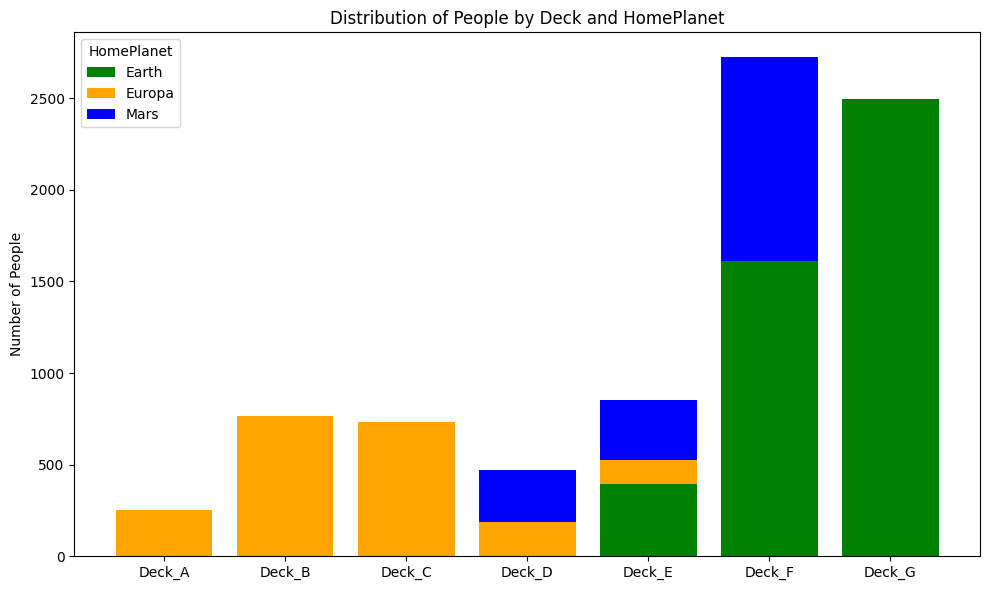

In [37]:
# Deck and HomePlanet lists
decks = ['Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G']
homeplanets = ['HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars']
colors = {'HomePlanet_Earth': 'green', 'HomePlanet_Europa': 'orange', 'HomePlanet_Mars': 'blue'}

# Count individuals per deck and homeplanet
counts = {}
for deck in decks:
    counts[deck] = {}
    for homeplanet in homeplanets:
        counts[deck][homeplanet] = len(train_data[(train_data[deck] == 1) & (train_data[homeplanet] == 1)])

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bars
bottoms = np.zeros(len(decks))
for homeplanet in homeplanets:
    heights = [counts[deck][homeplanet] for deck in decks]
    ax.bar(decks, heights, bottom=bottoms, label=homeplanet.split('_')[1], color=colors[homeplanet])
    bottoms += np.array(heights)

# Decorate the plot
ax.set_ylabel('Number of People')
ax.set_title('Distribution of People by Deck and HomePlanet')
ax.legend(title='HomePlanet')

plt.tight_layout()
plt.show()

#### I'm most surprised by Decks B and C. While the overall count of people on those decks is relatively small compared to F and G, They have a HIGHER representation in the transported population

#### People from Earth on Deck F are overrepresented in the transported population compared to Mars

### I still don't fully understand why people headed to Trappist are so much more likely to get abducted. 
#### Here's another correlation heatmap. This one looks only at people where were both abducted and were headed to Trappist

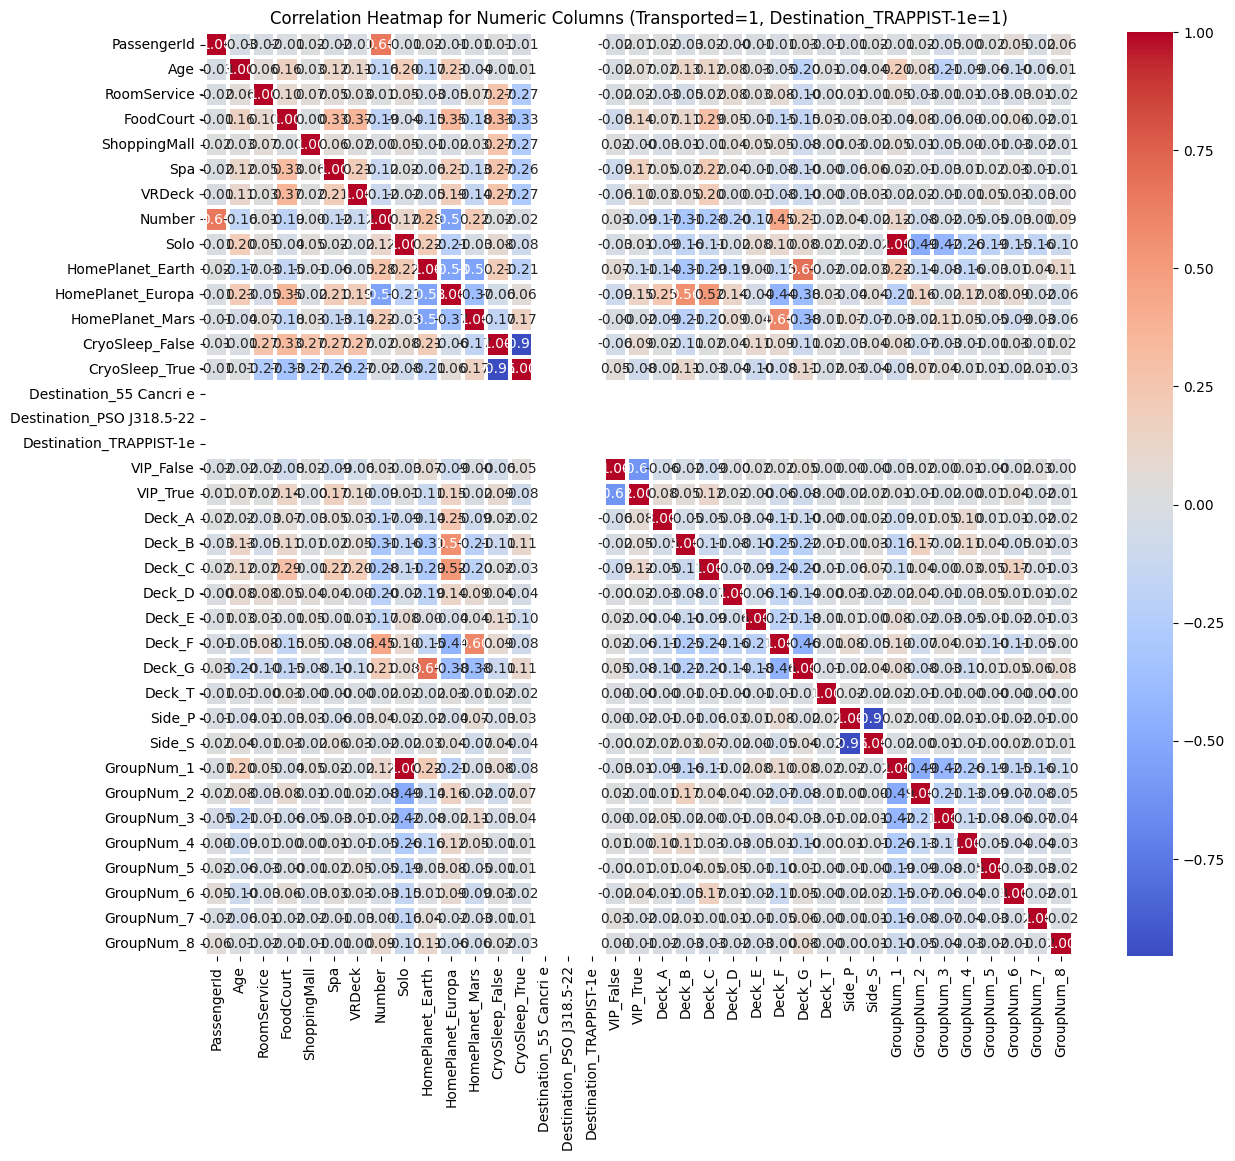

In [38]:
# Step 1: Filter the dataset for rows where 'Transported' is equal to 1
filtered_data = train_data[(train_data['Transported'] == 1) & (train_data['Destination_TRAPPIST-1e'] == 1)]

# Step 2: Create a DataFrame with only the selected numeric columns
numeric_columns = [col for col in filtered_data.columns if col not in categorical_columns and col not in ['Name', 'Transported']]
numeric_data = filtered_data[numeric_columns]

# Step 3: Compute the correlation matrix
correlation_matrix_numeric = numeric_data.corr()

# Step 4: Create a heatmap with increased linewidths and size
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1.5)
plt.title("Correlation Heatmap for Numeric Columns (Transported=1, Destination_TRAPPIST-1e=1)")
plt.show()

### This is so awesome. People headed to Trappist are more likely to be transported if they are not in cryosleep and are from Europa while spending money.
#### This supports my prior assertion that Decks B and C are overrepresented in the transported population, as they only consist of people from Europa.

## Let's see a breakdown of people NOT in CryoSleep who spent no money

In [39]:
# Filter the DataFrame based on multiple conditions
filtered_data_2 = train_data[
    (train_data['CryoSleep_True'] == False) &
    (train_data['RoomService'] == 0) &
    (train_data['FoodCourt'] == 0) &
    (train_data['ShoppingMall'] == 0) &
    (train_data['Spa'] == 0) &
    (train_data['VRDeck'] == 0)
]

# Describe the filtered DataFrame
filtered_data_2.describe()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Number,Solo,HomePlanet_Earth,HomePlanet_Europa,...,Side_P,Side_S,GroupNum_1,GroupNum_2,GroupNum_3,GroupNum_4,GroupNum_5,GroupNum_6,GroupNum_7,GroupNum_8
count,557.00,557.00,557.00,557.00,557.00,557.00,557.00,557.00,557.00,557.00,...,557.00,557.00,557.00,557.00,557.00,557.00,557.00,557.00,557.00,557.00
mean,12.95,0.00,0.00,0.00,0.00,0.00,611.26,0.21,0.56,0.18,...,0.49,0.49,0.21,0.16,0.26,0.12,0.09,0.08,0.06,0.01
std,14.53,0.00,0.00,0.00,0.00,0.00,479.91,0.41,0.50,0.38,...,0.50,0.50,0.41,0.37,0.44,0.33,0.28,0.27,0.24,0.12
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,0.00,0.00,0.00,0.00,0.00,184.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,8.00,0.00,0.00,0.00,0.00,0.00,505.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,20.00,0.00,0.00,0.00,0.00,0.00,994.00,0.00,1.00,0.00,...,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
max,71.00,0.00,0.00,0.00,0.00,0.00,1888.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [40]:
# Remove 'Name'

train_data.drop(columns=['Name'], inplace=True)
test_data.drop(columns=['Name'], inplace=True)


<a id="feature"></a> 
# Step 4: Feature Engineering
## Add all services in a new column titled "TotExpenses"

In [41]:
expendature = ['RoomService', 'FoodCourt', 'ShoppingMall', 'VRDeck', 'Spa']

for dataset in [train_data, test_data]:
    dataset['TotExpenses'] = dataset[expendature].sum(axis=1)

## If the person is over 16, they're not in CryoSleep, and they spent no money then add them to 'NoMoneySpent' column


In [42]:
for dataset in [train_data, test_data]:
    dataset['NoDoughSpent'] = (dataset['CryoSleep_False'] == 1) & (dataset['Age'] >= 16) & (dataset['TotExpenses'] == 0)
    dataset['NoDoughSpent'] = dataset['NoDoughSpent'].astype(int)

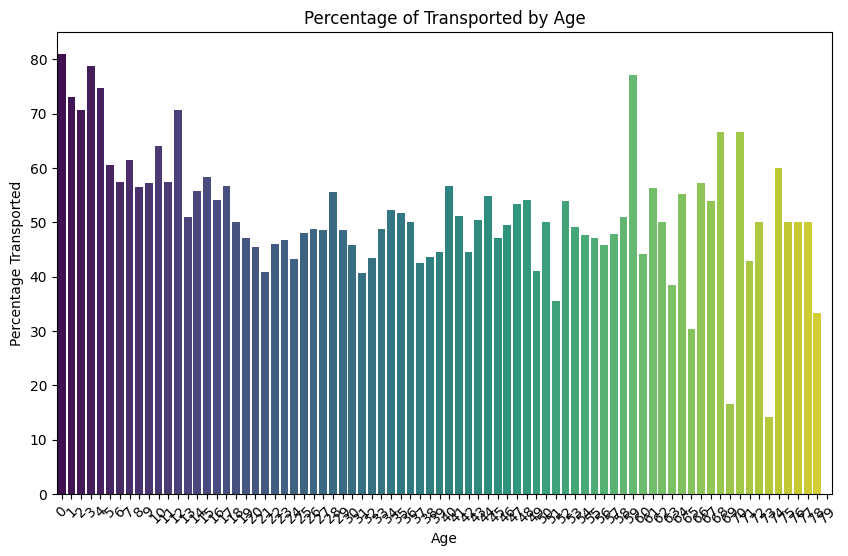

In [43]:
# Add a new column "AgeInt" by converting the "Age" column to integers
train_data['AgeInt'] = train_data['Age'].astype(int)

# Calculate the percentage of 'Transported' for each age group using "AgeInt"
age_transported_percentage = train_data.groupby('AgeInt')['Transported'].mean() * 100

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=age_transported_percentage.index, y=age_transported_percentage.values, palette='viridis')
plt.xlabel('Age')
plt.ylabel('Percentage Transported')
plt.title('Percentage of Transported by Age')
plt.xticks(rotation=45)
plt.show()

# Remove the "AgeInt" column
train_data.drop('AgeInt', axis=1, inplace=True)

## This is some pretty tight clustering. Let's bin it by 4s

In [44]:
# Defbin edges and labels
bin_edges = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80]
bin_labels = ['0-3', '4-7', '8-11', '12-15', '16-19', '20-23', '24-27', '28-31', '32-35', '36-39',
              '40-43', '44-47', '48-51', '52-55', '56-59', '60-63', '64-67', '68-71', '72-75', '76-79']

# Bin the 'Age' column in train_data and test_data
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=bin_edges, labels=bin_labels, right=False)
test_data['AgeGroup'] = pd.cut(test_data['Age'], bins=bin_edges, labels=bin_labels, right=False)

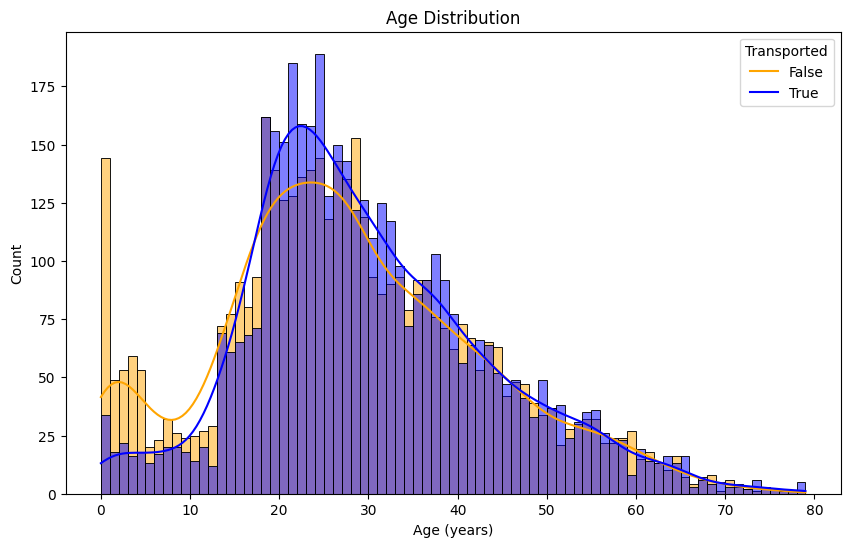

In [45]:
# Create a custom color palette with blue and green
custom_palette = ["blue", "orange"]

# Create the histogram with the custom color palette
plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='Age', hue='Transported', binwidth=1, kde=True, palette=custom_palette)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.legend(title='Transported', labels=['False', 'True'])
plt.show()

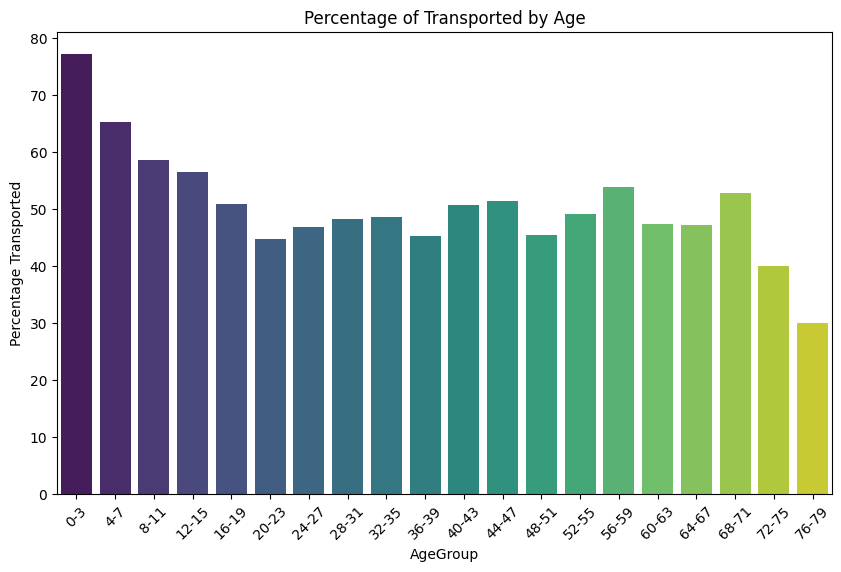

In [46]:
# Calculate the percentage of 'Transported' for each age group
age_transported_percentage = train_data.groupby('AgeGroup')['Transported'].mean() * 100

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=age_transported_percentage.index, y=age_transported_percentage.values, palette='viridis')
plt.xlabel('AgeGroup')
plt.ylabel('Percentage Transported')
plt.title('Percentage of Transported by Age')
plt.xticks(rotation=45)
plt.show()

## One-hot encode AgeGroup

In [47]:
train_data = pd.get_dummies(train_data, columns = ['AgeGroup'])
test_data = pd.get_dummies(test_data, columns = ['AgeGroup'])
combine = [train_data, test_data]

## Kids under 15 are more likely to be transported

### Credit for this next part goes to [Samuel Cortinhas](https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide)

## We find the numbers and bin them by 300s

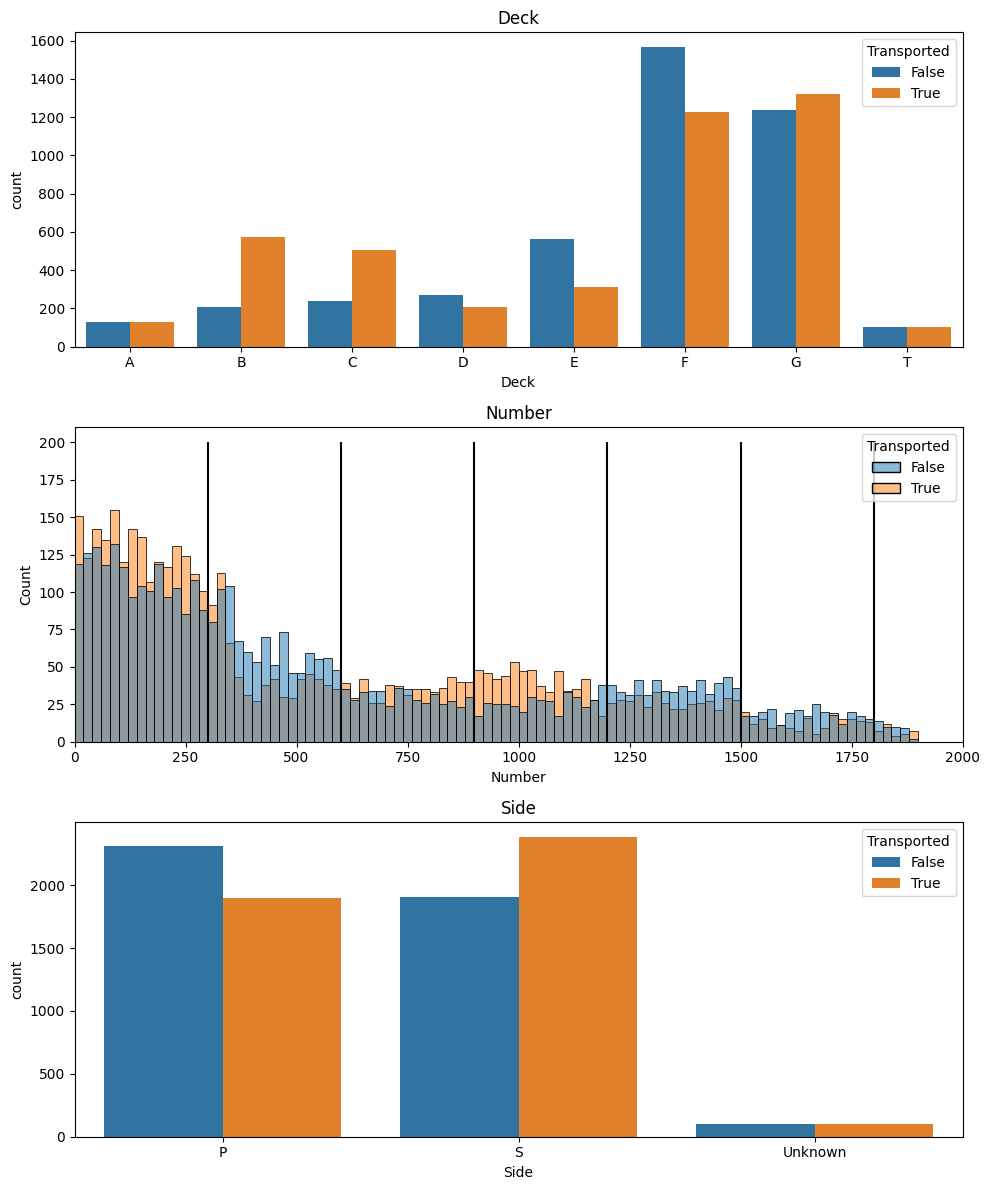

In [48]:
deck_conditions = [
    (train_data['Deck_A'] == 1),
    (train_data['Deck_B'] == 1),
    (train_data['Deck_C'] == 1),
    (train_data['Deck_D'] == 1),
    (train_data['Deck_E'] == 1),
    (train_data['Deck_F'] == 1),
    (train_data['Deck_G'] == 1)
]

deck_values = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

# Use numpy's select function to assign the appropriate value to the 'Deck' column
train_data['Deck'] = np.select(deck_conditions, deck_values, default='T')

# Create a new 'Side' column based on the Side_P and Side_S columns
side_conditions = [
    (train_data['Side_P'] == 1),
    (train_data['Side_S'] == 1)
]

side_values = ['P', 'S']

# Use numpy's select function to assign the appropriate value to the 'Side' column
train_data['Side'] = np.select(side_conditions, side_values, default='Unknown')

# Now you can plot the distribution with the 'Deck' and 'Side' columns
fig = plt.figure(figsize=(10, 12))
plt.subplot(3, 1, 1)
sns.countplot(data=train_data, x='Deck', hue='Transported', order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
plt.title('Deck')

plt.subplot(3, 1, 2)
sns.histplot(data=train_data, x='Number', hue='Transported', binwidth=20)
plt.vlines(300, ymin=0, ymax=200, color='black')
plt.vlines(600, ymin=0, ymax=200, color='black')
plt.vlines(900, ymin=0, ymax=200, color='black')
plt.vlines(1200, ymin=0, ymax=200, color='black')
plt.vlines(1500, ymin=0, ymax=200, color='black')
plt.vlines(1800, ymin=0, ymax=200, color='black')
plt.title('Number')
plt.xlim([0, 2000])

plt.subplot(3, 1, 3)
sns.countplot(data=train_data, x='Side', hue='Transported')
plt.title('Side')
fig.tight_layout()

plt.show()


In [49]:
# Function to add Cabin region features
def add_cabin_region_features(data):
    data['Cabin_region1'] = (data['Number'] < 300).astype(int)
    data['Cabin_region2'] = ((data['Number'] >= 300) & (data['Number'] < 600)).astype(int)
    data['Cabin_region3'] = ((data['Number'] >= 600) & (data['Number'] < 900)).astype(int)
    data['Cabin_region4'] = ((data['Number'] >= 900) & (data['Number'] < 1200)).astype(int)
    data['Cabin_region5'] = ((data['Number'] >= 1200) & (data['Number'] < 1500)).astype(int)
    data['Cabin_region6'] = ((data['Number'] >= 1500) & (data['Number'] < 1800)).astype(int)
    data['Cabin_region7'] = (data['Number'] >= 1800).astype(int)
    return data

# Apply the function to both train_data and test_data
train_data = add_cabin_region_features(train_data)
test_data = add_cabin_region_features(test_data)

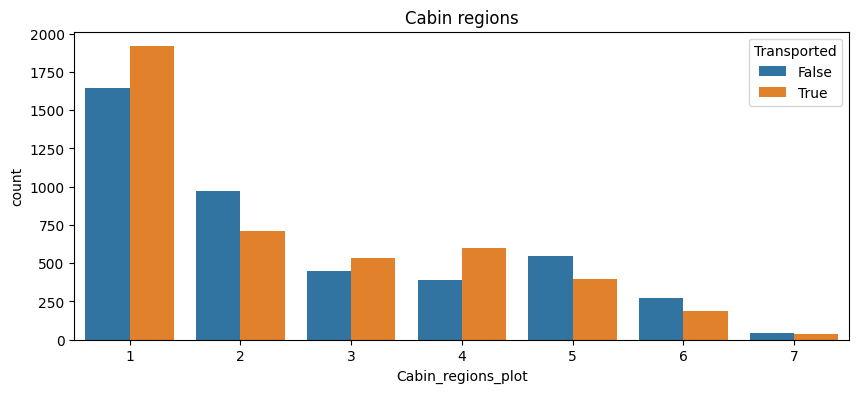

In [50]:
# Plot distribution of new features
plt.figure(figsize=(10, 4))
train_data['Cabin_regions_plot'] = (
    train_data['Cabin_region1'] +
    2 * train_data['Cabin_region2'] +
    3 * train_data['Cabin_region3'] +
    4 * train_data['Cabin_region4'] +
    5 * train_data['Cabin_region5'] +
    6 * train_data['Cabin_region6'] +
    7 * train_data['Cabin_region7']
).astype(int)

sns.countplot(data=train_data, x='Cabin_regions_plot', hue='Transported')
plt.title('Cabin regions')

# Drop 'Deck', 'Side', and 'Cabin_regions_plot'
train_data.drop(['Deck', 'Side', 'Cabin_regions_plot'], axis=1, inplace=True)

plt.show()

## Check out VIP

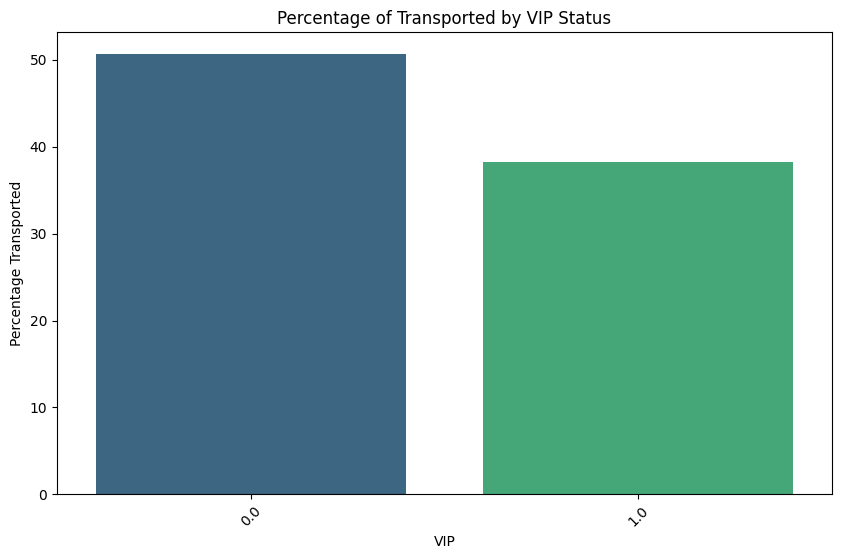

In [51]:
vip_transported_percentage = train_data.groupby('VIP_True')['Transported'].mean() * 100

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=vip_transported_percentage.index, y=vip_transported_percentage.values, palette='viridis')
plt.xlabel('VIP')
plt.ylabel('Percentage Transported')
plt.title('Percentage of Transported by VIP Status')
plt.xticks(rotation=45)
plt.show()

## People with VIP status are less likely to be transported

## Drop unneccessary columns to prevent overfitting


In [52]:

train_data.drop('Number', axis=1, inplace=True)
test_data.drop('Number', axis=1, inplace=True)
train_data.drop('Age', axis=1, inplace=True)
test_data.drop('Age', axis=1, inplace=True)


In [53]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PassengerId                8693 non-null   object 
 1   RoomService                8693 non-null   float64
 2   FoodCourt                  8693 non-null   float64
 3   ShoppingMall               8693 non-null   float64
 4   Spa                        8693 non-null   float64
 5   VRDeck                     8693 non-null   float64
 6   Transported                8693 non-null   bool   
 7   Solo                       8693 non-null   float64
 8   HomePlanet_Earth           8693 non-null   float64
 9   HomePlanet_Europa          8693 non-null   float64
 10  HomePlanet_Mars            8693 non-null   float64
 11  CryoSleep_False            8693 non-null   float64
 12  CryoSleep_True             8693 non-null   float64
 13  Destination_55 Cancri e    8693 non-null   float

In [54]:
features = [
    'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Solo',
    'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'CryoSleep_False', 'CryoSleep_True',
    'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'VIP_False', 'VIP_True',
    'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
    'Side_P', 'Side_S', 'GroupNum_1', 'GroupNum_2', 'GroupNum_3', 'GroupNum_4', 'GroupNum_5', 'GroupNum_6', 'GroupNum_7', 'GroupNum_8',
    'TotExpenses', 'NoDoughSpent',
    'AgeGroup_0-3', 'AgeGroup_4-7', 'AgeGroup_8-11', 'AgeGroup_12-15', 'AgeGroup_16-19', 'AgeGroup_20-23',
    'AgeGroup_24-27', 'AgeGroup_28-31', 'AgeGroup_32-35', 'AgeGroup_36-39', 'AgeGroup_40-43', 'AgeGroup_44-47',
    'AgeGroup_48-51', 'AgeGroup_52-55', 'AgeGroup_56-59', 'AgeGroup_60-63', 'AgeGroup_64-67', 'AgeGroup_68-71', 'AgeGroup_72-75', 'AgeGroup_76-79',
    'Cabin_region1', 'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5', 'Cabin_region6', 'Cabin_region7'
]

<a id="selection"></a> 
# Step 5: Model Selection

## LazyClassifier for a quick look at models

In [56]:
# Define X and y
X = pd.get_dummies(train_data[features])
y = train_data["Transported"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 64)
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models,pred = reg.fit(X_train, X_test, y_train, y_test)
models

 21%|██▏       | 9/42 [00:03<00:21,  1.55it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 74%|███████▍  | 31/42 [00:40<00:15,  1.40s/it]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


 79%|███████▊  | 33/42 [00:41<00:09,  1.05s/it]

RANSACRegressor model failed to execute
RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).


100%|██████████| 42/42 [00:50<00:00,  1.21s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.49,0.50,0.35,1.59
HistGradientBoostingRegressor,0.48,0.50,0.35,0.62
GradientBoostingRegressor,0.46,0.48,0.36,1.29
RandomForestRegressor,0.44,0.46,0.37,2.79
XGBRegressor,0.43,0.45,0.37,1.94
ExtraTreesRegressor,0.39,0.42,0.38,2.11
BaggingRegressor,0.39,0.41,0.38,0.27
NuSVR,0.37,0.40,0.39,2.73
SVR,0.37,0.39,0.39,2.28


In [57]:
X = train_data[features]
Y = train_data["Transported"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=64)

# Initialize LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Fit LazyClassifier on the training data
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Print the list of models and their performance metrics
print(models)

100%|██████████| 29/29 [00:25<00:00,  1.12it/s]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.82               0.82     0.82      0.82   
RandomForestClassifier             0.81               0.81     0.81      0.81   
LogisticRegression                 0.80               0.80     0.80      0.80   
CalibratedClassifierCV             0.80               0.80     0.80      0.80   
LinearSVC                          0.80               0.80     0.80      0.80   
AdaBoostClassifier                 0.80               0.80     0.80      0.80   
SVC                                0.80               0.80     0.80      0.80   
BaggingClassifier                  0.80               0.80     0.80      0.80   
NuSVC                              0.79               0.79     0.79      0.79   
XGBClassifier                      0.79               0.79     0.79      0.79   
LinearDiscriminantAnalysis  

## CatBoost

In [58]:
catboost_model = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=200)
catboost_model.fit(X_train, y_train)

0:	learn: 0.6470089	total: 51ms	remaining: 50.9s
200:	learn: 0.2984246	total: 711ms	remaining: 2.83s
400:	learn: 0.2376912	total: 1.42s	remaining: 2.12s
600:	learn: 0.1989324	total: 2.13s	remaining: 1.42s
800:	learn: 0.1708045	total: 2.83s	remaining: 704ms
999:	learn: 0.1503592	total: 3.53s	remaining: 0us


In [59]:
y_pred = catboost_model.predict(X_test)

In [60]:
# Convert y_pred to boolean
y_pred = y_pred.astype(bool)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {roc_auc:.2f}")

Accuracy: 0.49
AUC: 0.50


## XGBoost

In [61]:
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    objective='binary:logistic',
    verbosity=1,
    random_state=64
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=64, ...)

In [62]:
y_pred = xgb_model.predict(X_test)

In [63]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {roc_auc:.2f}")

Accuracy: 0.80
AUC: 0.80


### LGBMClassifier worked the best
#### Let's explore and fine-tune
## Lightgbm

In [64]:
lgb_model = lightgbm.LGBMClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.1,
    objective='binary',
    random_state=64
)

lgb_model.fit(X_train, y_train)

LGBMClassifier(max_depth=6, n_estimators=1000, objective='binary',
               random_state=64)

In [65]:
y_pred = lgb_model.predict(X_test)

In [66]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {roc_auc:.2f}")

Accuracy: 0.80
AUC: 0.80


<a id="tune"></a> 
# Step 7: Fine-Tuning

## Fine-tune hyperparameters using GridSearchCV
#### To my understanding, this searches all combinations of these hyperparameters to return the best result

In [67]:
# Define hyperparameters to test
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
}

In [68]:
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

In [69]:
# Fit the model to the hyperparameters
best_lgb_model = lightgbm.LGBMClassifier(**best_params, objective='binary', random_state=64)
best_lgb_model.fit(X_train, y_train)

LGBMClassifier(max_depth=3, n_estimators=200, objective='binary',
               random_state=64)

In [70]:
# Evaluate the test set
y_pred = best_lgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy:.2f}")
print(f"Best AUC: {roc_auc:.2f}")

Best Accuracy: 0.82
Best AUC: 0.82


In [71]:
best_params

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

### There we have it. We'll do an LGBMClassifier with learning_rate 0.1, max_depth: 3, n_estimators: 200

In [72]:
lgb_model = lightgbm.LGBMClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.1,
    objective='binary',
    random_state=64
)

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

### What are the most imortant features?

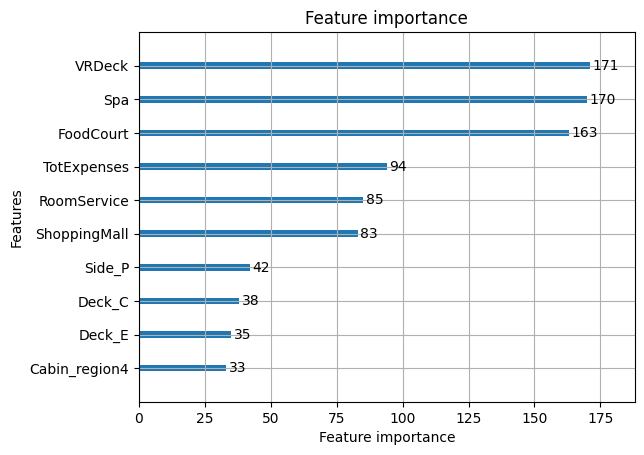

In [73]:
lightgbm.plot_importance(lgb_model, max_num_features=10)  
plt.show()

### Check for overfitting

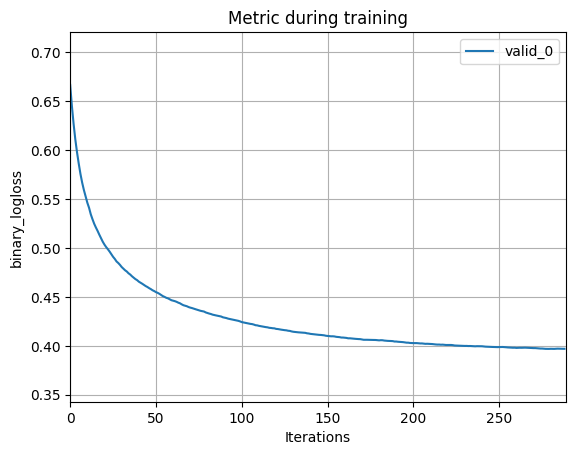

In [74]:
# Create a dataset for evaluation
eval_dataset = lightgbm.Dataset(X_test, label=y_test, reference=lgb_model)

# Train the LightGBM model and specify the evaluation dataset
lgb_model = lightgbm.LGBMClassifier(
    n_estimators=1000,
    max_depth=2,
    learning_rate=0.1,
    objective='binary',
    random_state=64
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='binary_logloss',  # Specify the metric for evaluation
    early_stopping_rounds=10,  # Optional: Stop training if the metric doesn't improve
    verbose=False  # Optional: Set to True for training progress output
)

# Plot the learning curve
lightgbm.plot_metric(lgb_model, metric='binary_logloss')
plt.show()

#### We want to see it level off like this. It means it's not overfitted. It also makes me want to test again using the 220 nestimators instead of 200. 
## Let's try that now

In [75]:
lgb_model = lightgbm.LGBMClassifier(
    n_estimators=220,
    max_depth=3,
    learning_rate=0.1,
    objective='binary',
    random_state=64
)

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)

In [76]:
# Evaluate the test set
y_pred = best_lgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Best Accuracy: {accuracy:.2f}")
print(f"Best AUC: {roc_auc:.2f}")

Best Accuracy: 0.82
Best AUC: 0.82


### Check out the ROC Curve
We know the Area Under the Curve is .82. Let's visualize this.

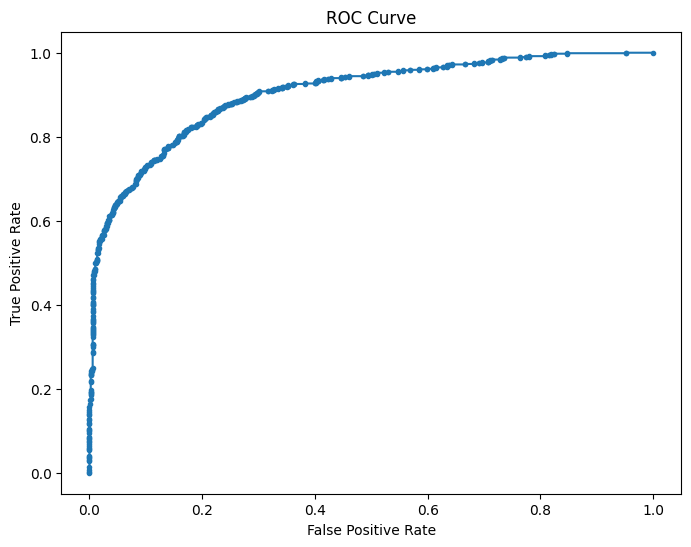

In [77]:
y_pred_prob = lgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

<a id="model"></a> 
# Step 7: Modeling

#### Define variables

In [78]:
target = "Transported"

# Split the data into training and testing sets
X_train = train_data[features]
y_train = train_data[target]

# Define the hyperparameters
params = {
    'n_estimators': 220,
    'max_depth': 3,
    'learning_rate': 0.1,
    'objective': 'binary',
    'random_state': 64
}

In [79]:
# Initialize and train the LightGBM model
lightgbm_model = lightgbm.LGBMClassifier(**params)
lightgbm_model.fit(X_train, y_train)

# Make predictions on the test data
X_test = test_data[features]
predictions = lightgbm_model.predict(X_test)

# Add the predictions to the test_data DataFrame
test_data['Transported'] = predictions

In [80]:
output = test_data[['PassengerId', 'Transported']]

In [81]:
output.to_csv('/kaggle/working/submission.csv', index=False)
output.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


# Thank you for reading!
#### See something I did wrong, or could do better? Please let me know!I'm here to learn.